In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import glob, re

import sys
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib import colors

sys.path.append('../../../src')
from m3_learning.RHEED.Analysis_umich import plot_activation_energy, select_range
from m3_learning.RHEED.Analysis import detect_peaks, process_rheed_data, process_curves
from m3_learning.RHEED.Fitting import fit_exp_function, normalize_and_extract_amplitude, de_normalize_and_assemble, fit_curves
from m3_learning.viz.layout import layout_fig
from m3_learning.RHEED.Viz import Viz

In [2]:
expo_time = 20
camera_freq = 1000/expo_time
laser_freq = 2

denoise_params = {'savgol_window_order': (3, 2), 'pca_component': 2, 'fft_cutoff_order':None, 'median_kernel_size':None}
curve_params = {'trim_first':0, 'tune_tail':False, 'convolve_step':5, 'prominence':10, 'mode':'valid', 'linear_ratio':0.8}
# normalize_params = {'I_diff': None, 'unify':False, 'bounds':[0.2, 20], 'p_init':(15, 5), 'n_std':3}
normalize_params = {'I_diff': None, 'unify':False, 'bounds':None, 'p_init':None, 'n_std':3}
viz_params = {'viz_denoise': True, 'viz_curves': True, 'viz_fittings': True, 'viz_ab': False}


(80715, 4)


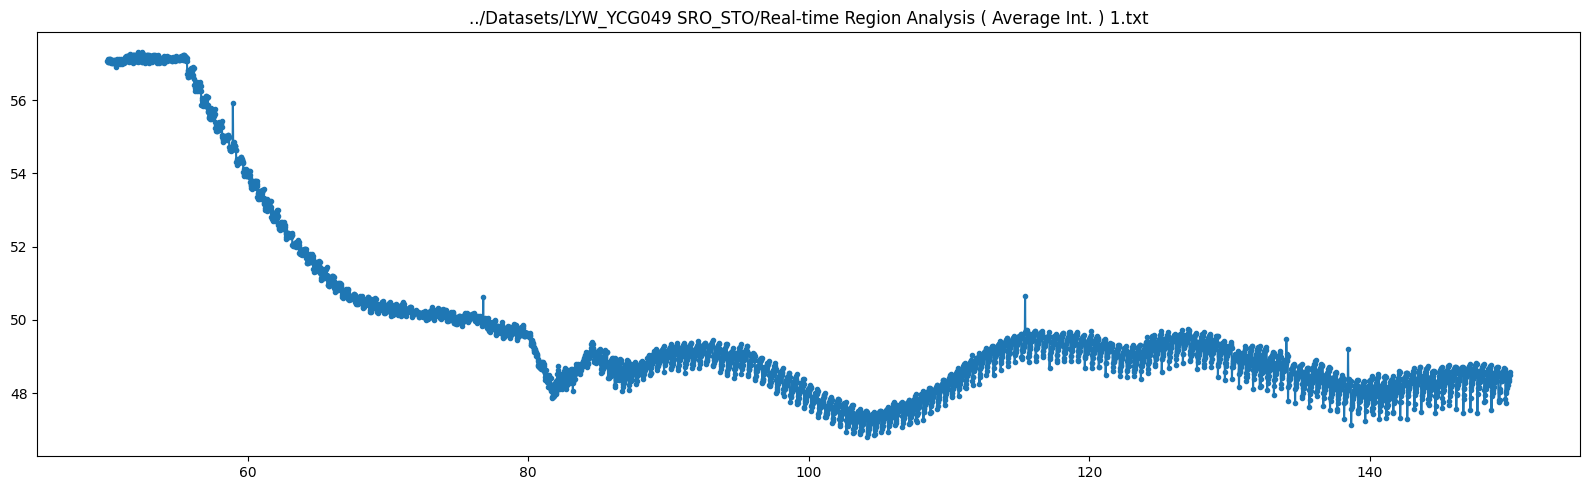

In [3]:
file = '../Datasets/LYW_YCG049 SRO_STO/Real-time Region Analysis ( Average Int. ) 1.txt'
data = np.loadtxt(file)
print(data.shape)
data = select_range(data, 50, 150, y_col=2)
plt.subplots(1, 1, figsize=(16,5))
plt.plot(data[:,0], data[:,1], marker='o', markersize=3)
plt.title(file)
plt.tight_layout()
plt.show()

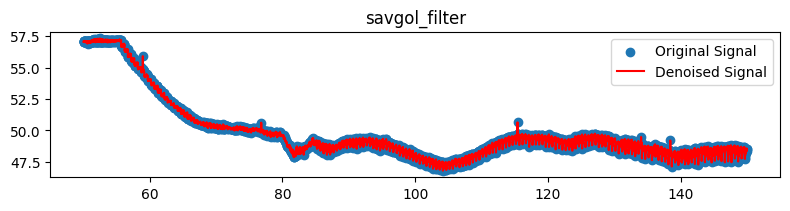

(4960,) (4960,)


In [4]:
denoise_params = {'savgol_window_order': (3, 2), 'pca_component': None, 'fft_cutoff_order':None, 'median_kernel_size':None}

if isinstance(data, str):
    data = np.loadtxt(data)
sample_x, sample_y = data[:,0], data[:,1]

# denoise
sample_x, sample_y = process_rheed_data(sample_x, sample_y, camera_freq, denoise_params, viz_params['viz_denoise'])  
print(sample_x.shape, sample_y.shape)    

200 200


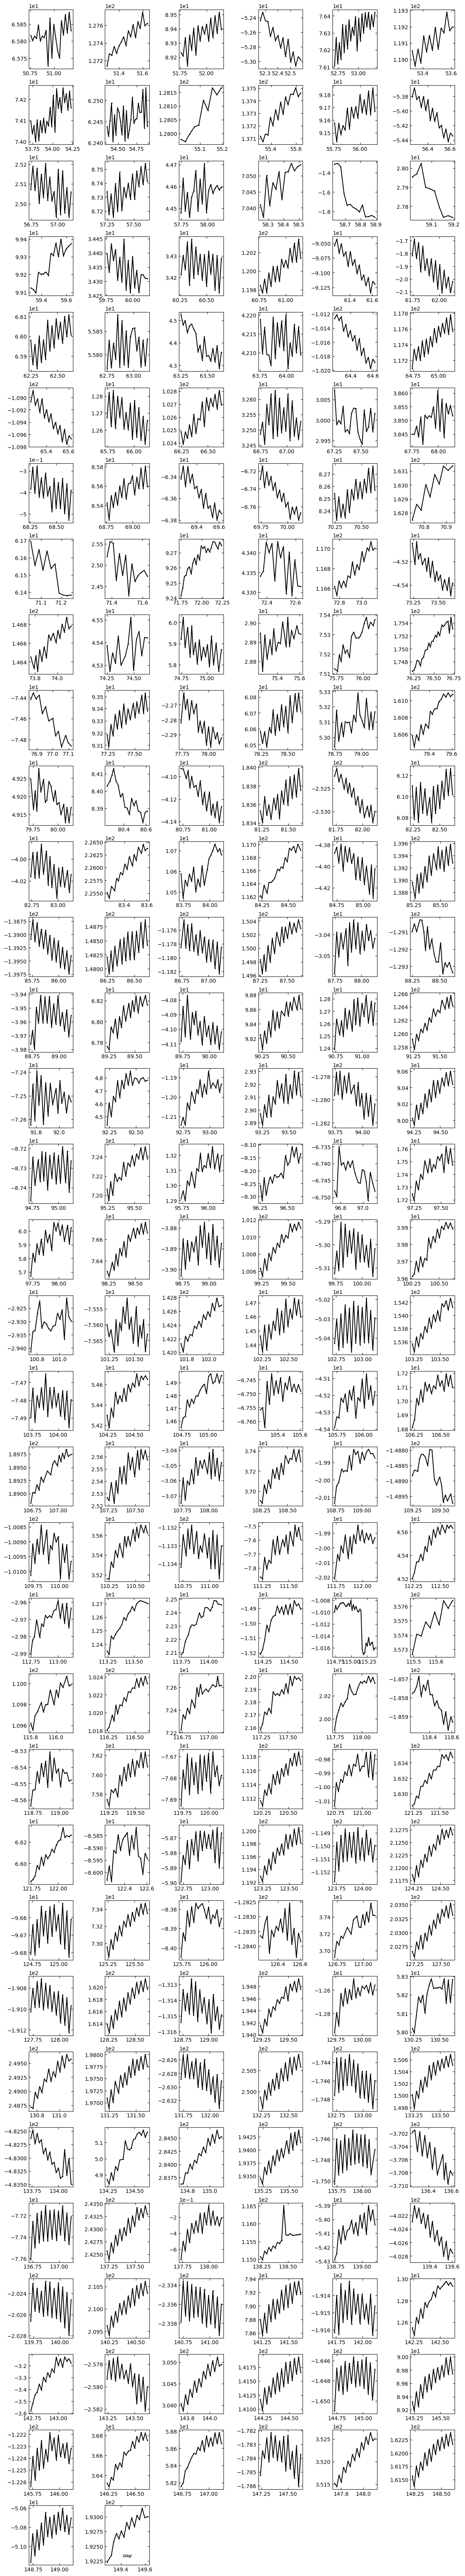

In [5]:
expo_time = 20
camera_freq = 1000/expo_time
laser_freq = 2
curve_params = {'trim_first':0, 'tune_tail':True, 'convolve_step':2, 'prominence':0.1, 'mode':'valid', 'linear_ratio':0.3}

# detect peaks
# print(sample_y[0].shape, sample_y[1].shape)
x_peaks, xs, ys = detect_peaks(sample_x, sample_y, camera_freq=camera_freq, laser_freq=laser_freq, curve_params=curve_params)

# denoise
xs, ys = process_curves(xs, ys, curve_params)     
print(len(xs), len(ys))  

# viz curves
if viz_params['viz_curves']:
    xs_sample, ys_sample = xs[::1], ys[::1]
    fig, axes = layout_fig(len(ys_sample), mod=6, figsize=(12,2*len(ys_sample)//6+1), layout='compressed')
    Viz.show_grid_plots(axes, xs_sample, ys_sample, labels=None, xlabel=None, ylabel=None, ylim=None, legend=None, color=None)

In [6]:
fit_settings = {'I_diff': None, 'unify': True, 'bounds': [0.01, 1], 'p_init': (1, 0.1, 0.4), 'n_std': 1}
growth_name='YG049'


I_diff = fit_settings['I_diff']
unify = fit_settings['unify']

# Step 1: Normalize and extract amplitude
ys_nor, I_starts, I_ends = normalize_and_extract_amplitude(xs, ys, I_diff, unify)

# Step 2: Fit curves
parameters, ys_nor_fit, ys_nor_fit_failed, labels, losses = fit_curves(xs, ys_nor, fit_settings, growth_name)

# Step 3: De-normalize and assemble results
ys_fit = de_normalize_and_assemble(xs, ys, ys_nor_fit, I_starts, I_ends, I_diff, unify)

parameters = np.array(parameters)
metadata = [xs, ys, ys_fit, ys_nor, ys_nor_fit, ys_nor_fit_failed, labels, losses]

# parameters, metadata = fit_exp_function(xs, ys, growth_name='YG049', fit_settings=fit_settings)
a, b, tau = parameters[:,0], parameters[:,1], parameters[:,2]
[xs, ys, ys_fit, ys_nor, ys_nor_fit, ys_nor_fit_failed, labels, losses] = metadata
x_coors = x_peaks[:-1]

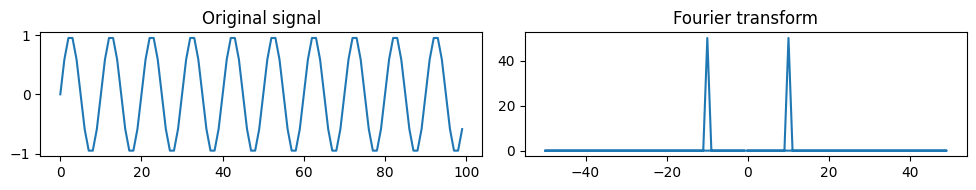

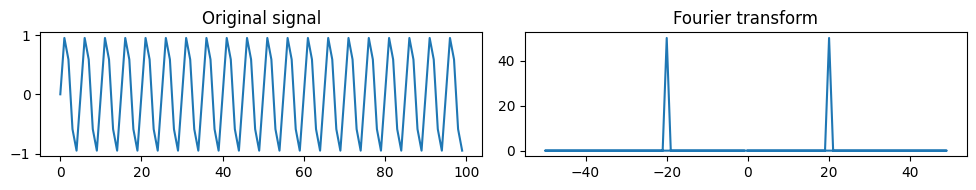

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, ifft

# Generate synthetic mixed signals
fs = 100  # Sampling frequency
t = np.arange(0, 1, 1/fs)  # Time vector

# Original signals
signal1 = np.sin(2 * np.pi * 10 * t)  # 10 Hz
signal2 = np.sin(2 * np.pi * 20 * t)  # 20 Hz

for signal in [signal1, signal2]:
    # Perform FFT
    n = len(t)
    f = np.fft.fftfreq(n, 1/fs)
    signal_fft = fft(signal)

    fig, axes = plt.subplots(1, 2, figsize=(10, 2))
    axes[0].plot(signal)
    axes[0].set_title('Original signal')
    axes[1].plot(f, np.abs(signal_fft))
    axes[1].set_title('Fourier transform')
    plt.tight_layout()
    plt.show()


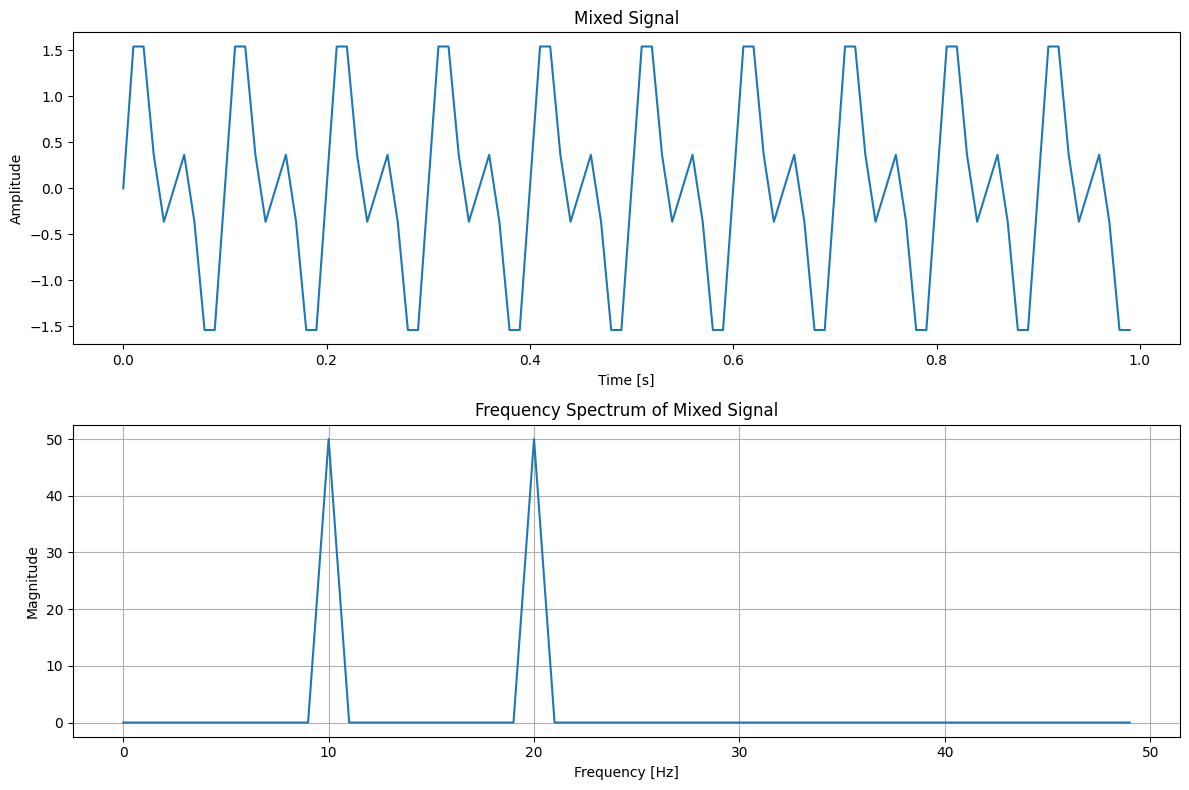

In [40]:
# Mixed signal
mixed_signal = signal1 + signal2

# Perform FFT
n = len(t)
f = np.fft.fftfreq(n, 1/fs)
mixed_signal_fft = fft(mixed_signal)

# Plot the mixed signal and its frequency spectrum
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(t, mixed_signal)
plt.title('Mixed Signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')

plt.subplot(2, 1, 2)
plt.plot(f[:n//2], np.abs(mixed_signal_fft)[:n//2])
plt.title('Frequency Spectrum of Mixed Signal')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude')
plt.grid()

plt.tight_layout()
plt.show()

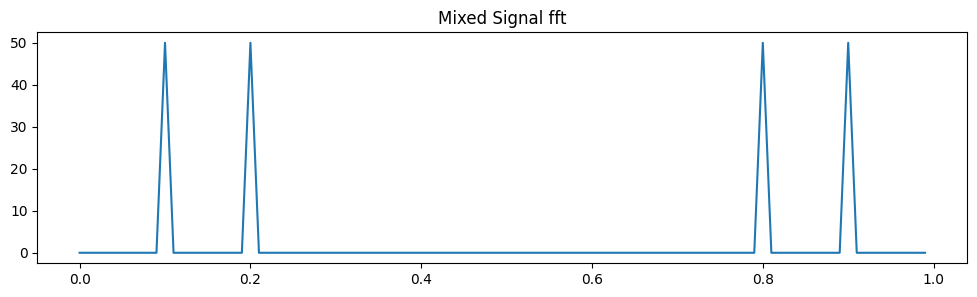

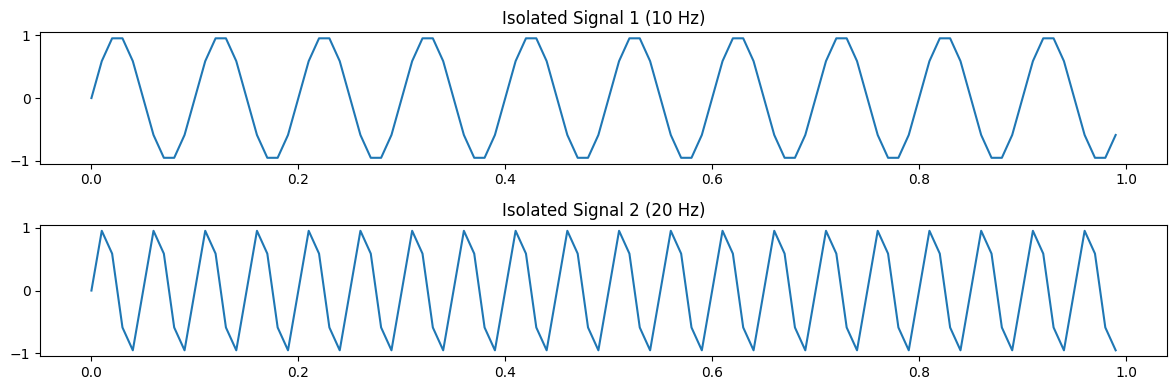

In [41]:
# Filter signals (band-pass filters)
def bandpass_filter(signal_fft, freq, fs, lowcut, highcut):
    f = np.fft.fftfreq(len(signal_fft), 1/fs)
    filter_mask = np.logical_and(freq >= lowcut, freq <= highcut)
    filter_mask = np.logical_or(filter_mask, np.logical_and(freq <= -lowcut, freq >= -highcut))
    filtered_fft = signal_fft * filter_mask
    return ifft(filtered_fft)

# Isolate each frequency component
signal1_filtered = bandpass_filter(mixed_signal_fft, f, fs, 5, 15)
signal2_filtered = bandpass_filter(mixed_signal_fft, f, fs, 15, 25)

# Plot isolated signals
plt.figure(figsize=(12, 4))

plt.subplot(2, 1, 1)
plt.plot(t, signal1_filtered.real)
plt.title('Isolated Signal 1 (10 Hz)')

plt.subplot(2, 1, 2)
plt.plot(t, signal2_filtered.real)
plt.title('Isolated Signal 2 (20 Hz)')

plt.tight_layout()
plt.show()


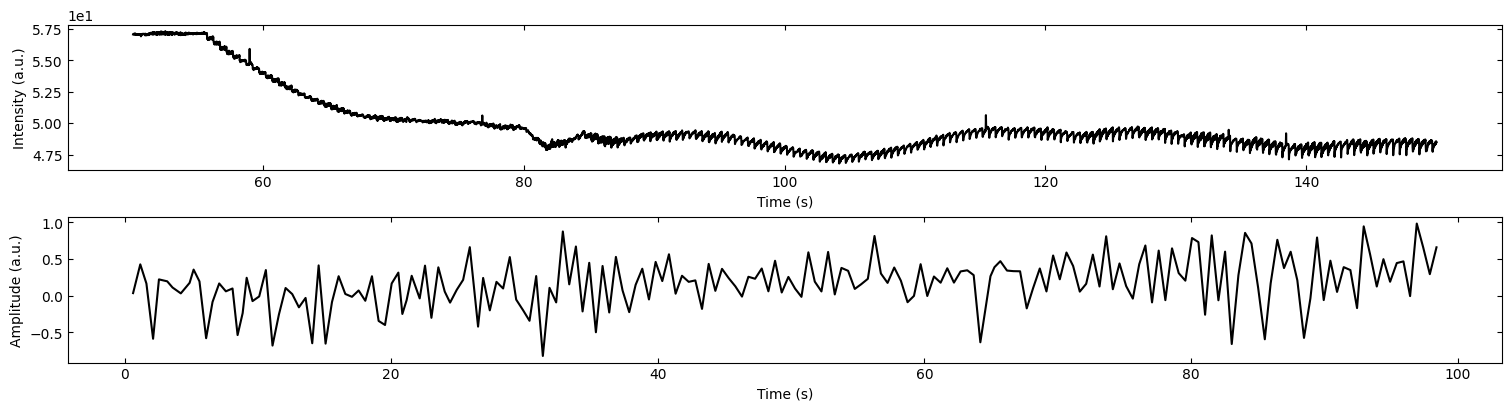

In [14]:
I_starts, I_ends = np.array(I_starts), np.array(I_ends)
I_diff = I_ends - I_starts

fig, axes = layout_fig(2, 1, figsize=(15, 2*2))
Viz.plot_curve(axes[0], sample_x, sample_y, plot_type='lineplot', xlabel='Time (s)', ylabel='Intensity (a.u.)', yaxis_style='sci')
Viz.plot_curve(axes[1], x_coors, I_diff, plot_type='lineplot', xlabel='Time (s)', ylabel='Amplitude (a.u.)', yaxis_style='sci')
plt.show()

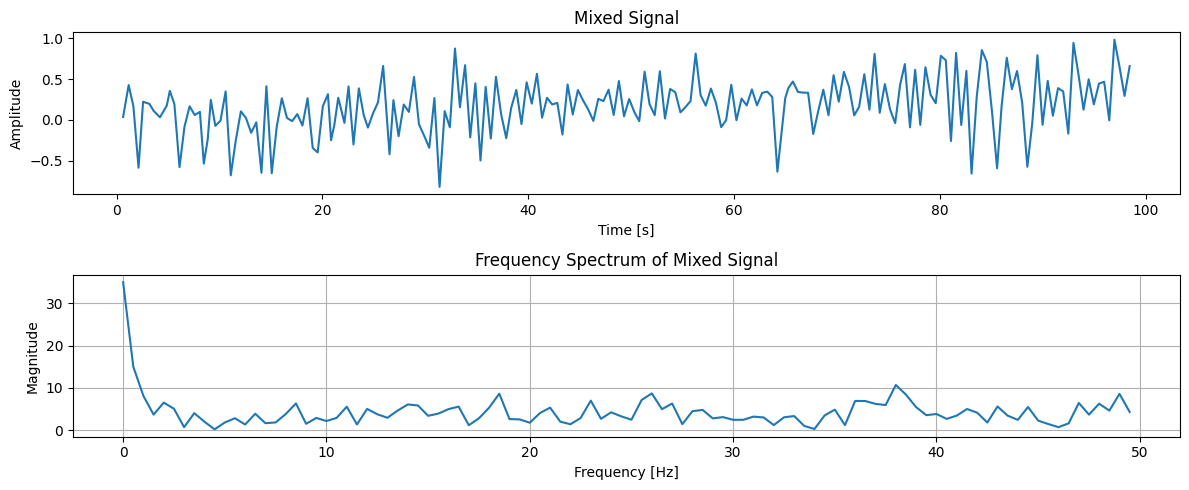

In [44]:
t = x_coors

# Mixed signal
mixed_signal = I_diff

# Perform FFT
n = len(t)
f = np.fft.fftfreq(n, 1/fs)
mixed_signal_fft = fft(mixed_signal)

# Plot the mixed signal and its frequency spectrum
fig, axes = plt.subplots(2, 1, figsize=(12, 5))
axes[0].plot(t, mixed_signal)
axes[0].set_title('Mixed Signal')
axes[0].set_xlabel('Time [s]')
axes[0].set_ylabel('Amplitude')
axes[1].plot(f[:n//2], np.abs(mixed_signal_fft)[:n//2])
axes[1].set_title('Frequency Spectrum of Mixed Signal')
axes[1].set_xlabel('Frequency [Hz]')
axes[1].set_ylabel('Magnitude')
axes[1].grid()
plt.tight_layout()
plt.show()

In [7]:
print(sample_x.shape, sample_y.shape, x_coors.shape, a.shape, b.shape, tau.shape)

(4960,) (4960,) (200,) (200,) (200,) (200,)


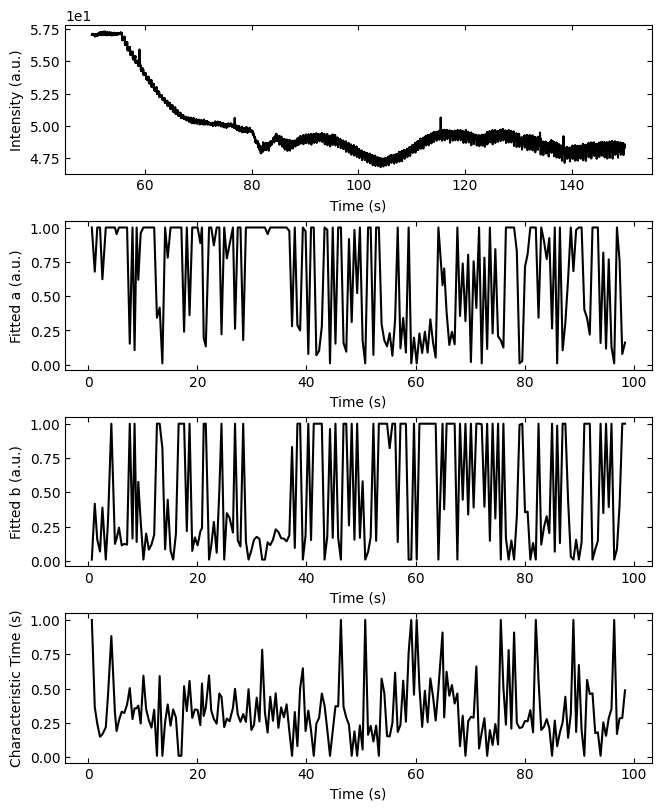

In [8]:
fig, axes = layout_fig(4, 1, figsize=(6.5, 2*4))
Viz.plot_curve(axes[0], sample_x, sample_y, plot_type='lineplot', xlabel='Time (s)', ylabel='Intensity (a.u.)', yaxis_style='sci')
Viz.plot_curve(axes[1], x_coors, a, plot_type='lineplot', xlabel='Time (s)', ylabel='Fitted a (a.u.)')
Viz.plot_curve(axes[2], x_coors, b, plot_type='lineplot', xlabel='Time (s)', ylabel='Fitted b (a.u.)')
Viz.plot_curve(axes[3], x_coors, tau, plot_type='lineplot', xlabel='Time (s)', ylabel='Characteristic Time (s)')
plt.show()

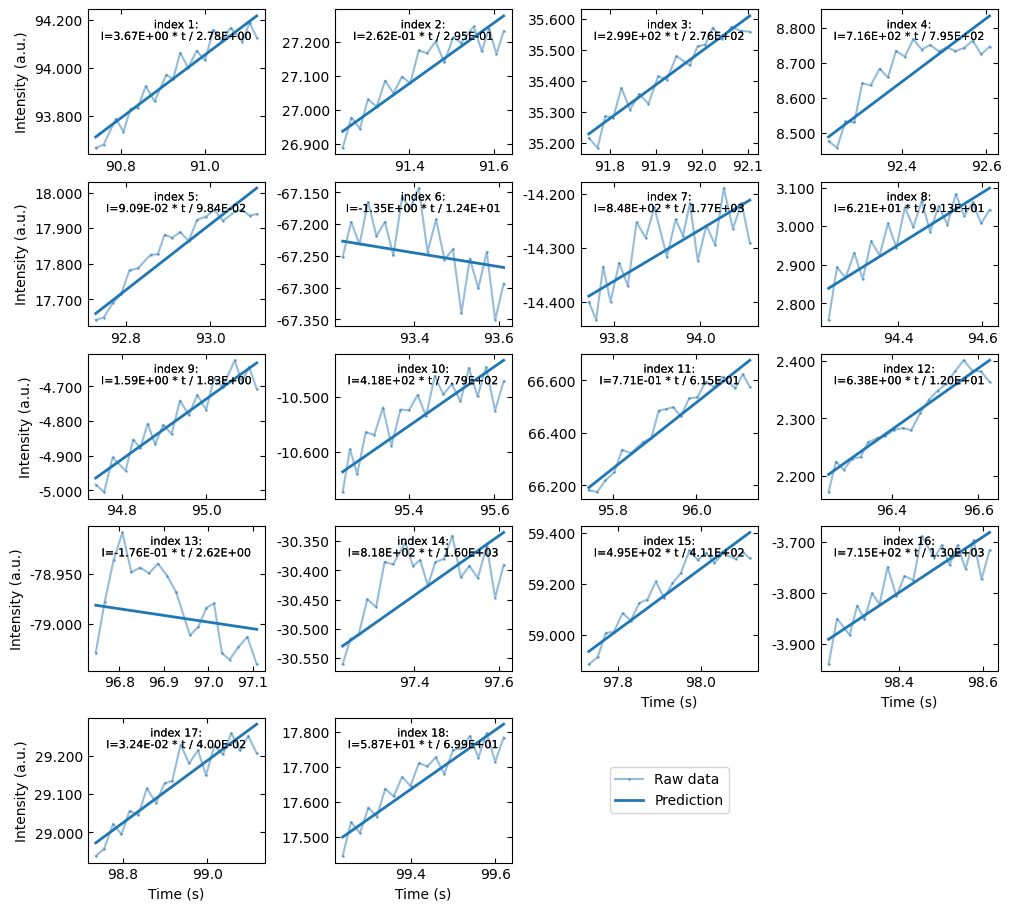

In [121]:
# fit exponential function
b_list, tau_list, ys_fit, labels = fit_tau(xs, ys, normalize_params=normalize_params)

# viz fittings
if viz_params['viz_fittings']:
    Viz.plot_fit_details(xs, ys, ys_fit, y3=None, labels=labels, figsize=(10, 1.8*len(xs)//4+1), mod=4, style='presentation', logscale=False)  

(33037, 4)


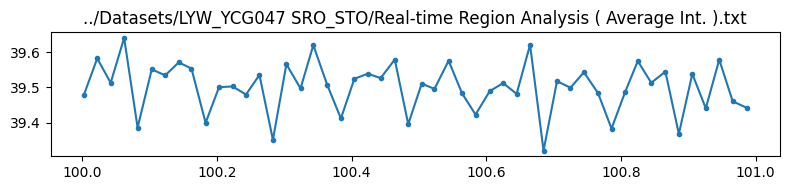

In [13]:
file = '../Datasets/LYW_YCG047 SRO_STO/Real-time Region Analysis ( Average Int. ).txt'
data = np.loadtxt(file)
print(data.shape)

data = select_range(data, 100, 101, y_col=3)

plt.subplots(1, 1, figsize=(8,2))
plt.plot(data[:,0], data[:,1], marker='o', markersize=3)
plt.title(file)
plt.tight_layout()
plt.show()

(59820, 4)


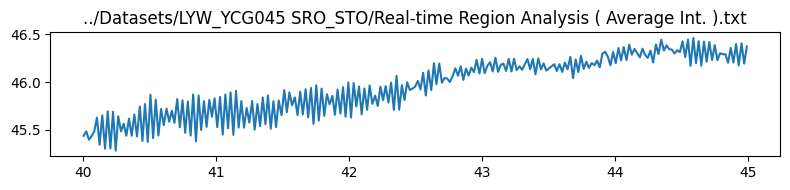

In [6]:
file = '../Datasets/LYW_YCG045 SRO_STO/Real-time Region Analysis ( Average Int. ).txt'
data = np.loadtxt(file)
print(data.shape)

data = select_range(data, 40, 45, y_col=3)

plt.subplots(1, 1, figsize=(8,2))
plt.plot(data[:,0], data[:,1])
plt.title(file)
plt.tight_layout()
plt.show()

In [10]:
file = '../Datasets/LYW_YCG046 SRO_STO/Real-time Region Analysis ( Average Int. ).txt'
data = np.loadtxt(file)
print(data.shape)

(42895, 4)


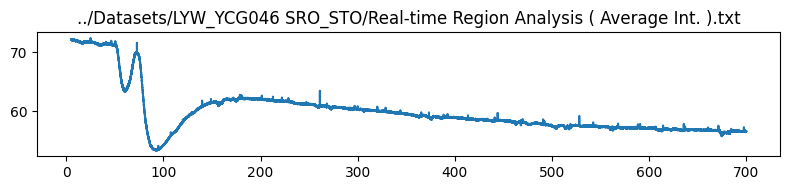

In [11]:
data_ = select_range(data, 0, 700, y_col=1)
plt.subplots(1, 1, figsize=(8,2))
plt.plot(data_[:,0], data_[:,1])
plt.title(file)
plt.tight_layout()
plt.show()

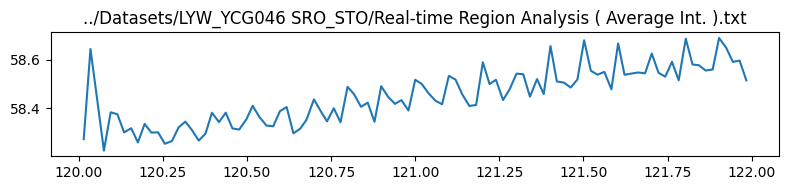

In [7]:
data_ = select_range(data, 120, 122, y_col=1)
plt.subplots(1, 1, figsize=(8,2))
plt.plot(data_[:,0], data_[:,1])
plt.title(file)
plt.tight_layout()
plt.show()

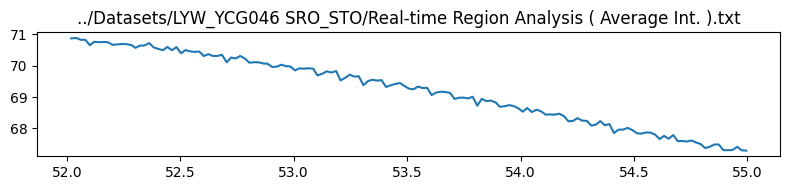

In [38]:
data_ = select_range(data, 52, 55, y_col=1)
plt.subplots(1, 1, figsize=(8,2))
plt.plot(data_[:,0], data_[:,1])
plt.title(file)
plt.tight_layout()
plt.show()

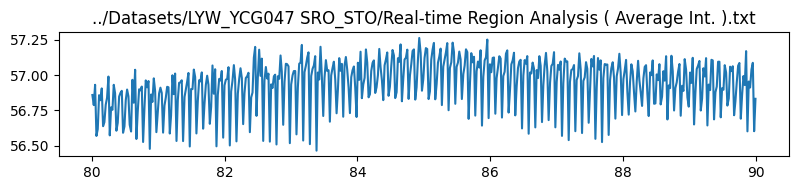

In [19]:
file = '../Datasets/LYW_YCG047 SRO_STO/Real-time Region Analysis ( Average Int. ).txt'
data = np.loadtxt(file)

data_ = select_range(data, 80, 90, y_col=2)
plt.subplots(1, 1, figsize=(8,2))
plt.plot(data_[:,0], data_[:,1])
plt.title(file)
plt.tight_layout()
plt.show()

In [ ]:
expo_time = 50
camera_freq = 1000/expo_time
laser_freq = 10

denoise_params = {'savgol_window_order': (3, 2), 'pca_component': None, 'fft_cutoff_order':None, 'median_kernel_size':None}
curve_params = {'trim_first':0, 'tune_tail':False, 'convolve_step':5, 'prominence':10, 'mode':'valid', 'linear_ratio':0.8}
# normalize_params = {'I_diff': None, 'unify':False, 'bounds':[0.2, 20], 'p_init':(15, 5), 'n_std':3}
normalize_params = {'I_diff': None, 'unify':False, 'bounds':None, 'p_init':None, 'n_std':3}
viz_params = {'viz_denoise': True, 'viz_curves': True, 'viz_fittings': True, 'viz_ab': False}

b_list, tau_list, ys_fit, labels = analyze_rheed_data_txt(data, camera_freq, laser_freq, denoise_params, curve_params, normalize_params, viz_params)  

# Growth Mechanism with Details

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib import colors

sys.path.append('../../../src/')
from m3_learning.nn.random import random_seed
from m3_learning.viz.style import set_style
from m3_learning.viz.printing import printer
from m3_learning.viz.layout import imagemap, layout_fig, labelfigs
from m3_learning.RHEED.Dataset import RHEED_parameter_dataset, RHEED_spot_Dataset
from m3_learning.RHEED.Viz import Viz
from m3_learning.RHEED.Analysis import detect_peaks, analyze_curves, process_rheed_data, normalize_0_1, reset_tails, remove_linear_bg, denoise_fft, denoise_median
from m3_learning.RHEED.Packed_functions import decay_curve_examples
from m3_learning.RHEED.Analysis_umich import fit_curves, analyze_rheed_data, select_range, plot_activation_energy

plot_size = (6, 2)
color_blue = (44/255,123/255,182/255)
color_gray = (128/255, 128/255, 128/255, 0.5)
seq_colors = ['#00429d','#2e59a8','#4771b2','#5d8abd','#73a2c6','#8abccf','#a5d5d8','#c5eddf','#ffffe0']
bgc1, bgc2 = (*colors.hex2color(seq_colors[0]), 0.3), (*colors.hex2color(seq_colors[5]), 0.3)

## 1. Visualize the spots from collected data

In [4]:
para_path = '../'
ds_para = RHEED_parameter_dataset(para_path, camera_freq=1000, sample_name='PM16')
ds_para.data_info

Growth: temp630:
--spot: spot_1:
----height:, Size of data: (25568,)
----img_max:, Size of data: (25568,)
----img_mean:, Size of data: (25568,)
----img_rec_max:, Size of data: (25568,)
----img_rec_mean:, Size of data: (25568,)
----img_rec_sum:, Size of data: (25568,)
----img_sum:, Size of data: (25568,)
----raw_image:, Size of data: (25568, 14, 8)
----reconstructed_image:, Size of data: (25568, 14, 8)
----width_x:, Size of data: (25568,)
----width_y:, Size of data: (25568,)
----x:, Size of data: (25568,)
----y:, Size of data: (25568,)
--spot: spot_2:
----height:, Size of data: (25568,)
----img_max:, Size of data: (25568,)
----img_mean:, Size of data: (25568,)
----img_rec_max:, Size of data: (25568,)
----img_rec_mean:, Size of data: (25568,)
----img_rec_sum:, Size of data: (25568,)
----img_sum:, Size of data: (25568,)
----raw_image:, Size of data: (25568, 17, 18)
----reconstructed_image:, Size of data: (25568, 17, 18)
----width_x:, Size of data: (25568,)
----width_y:, Size of data: (255

## 2. Analyze the Decay Curve

height


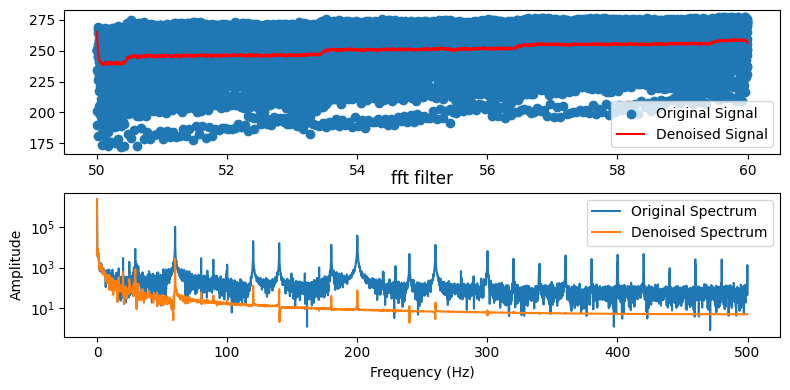

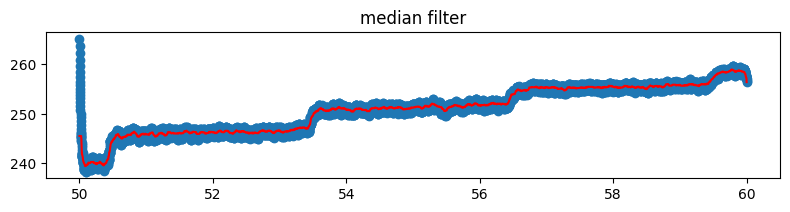

x


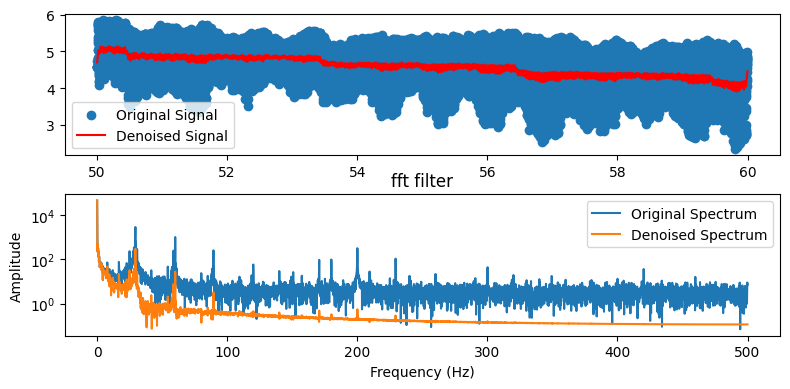

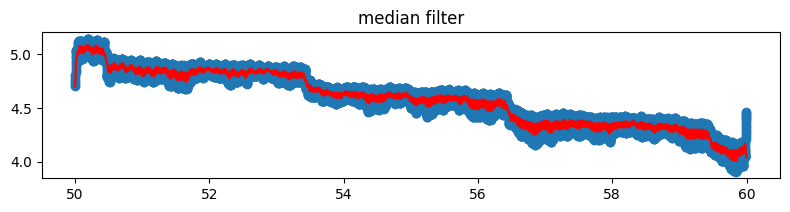

y


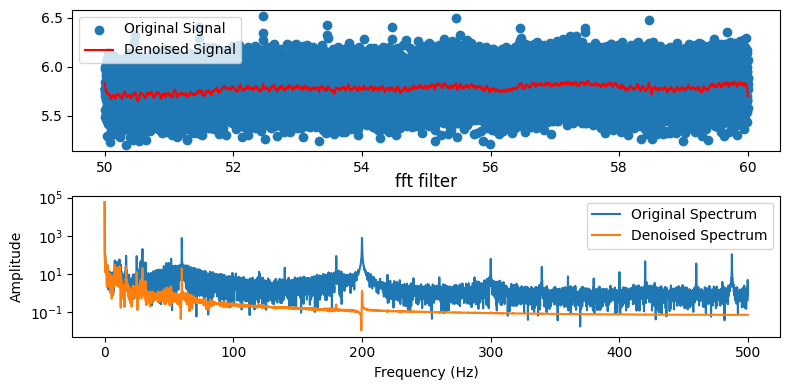

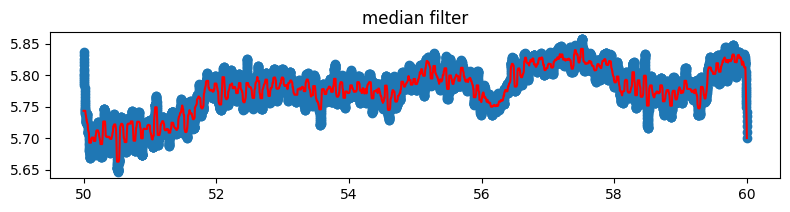

width_x


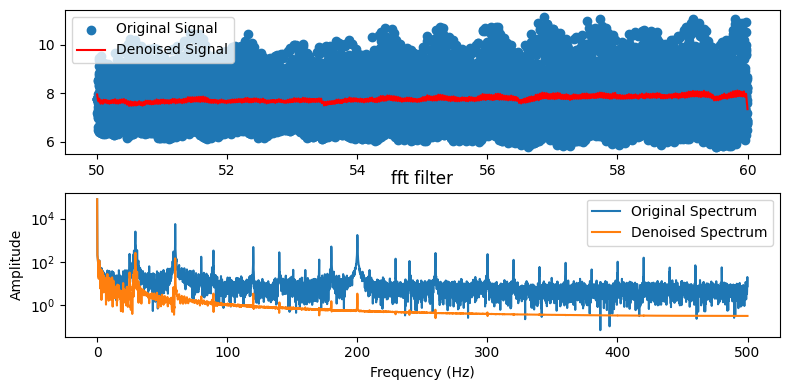

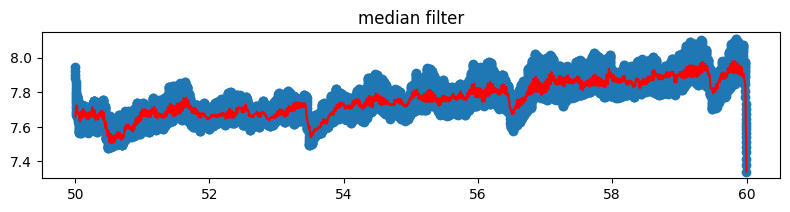

width_y


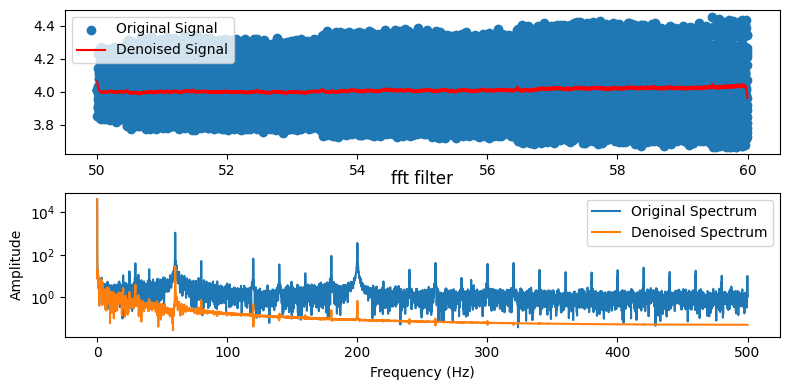

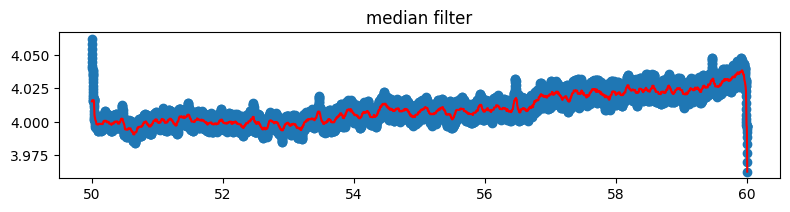

img_rec_max


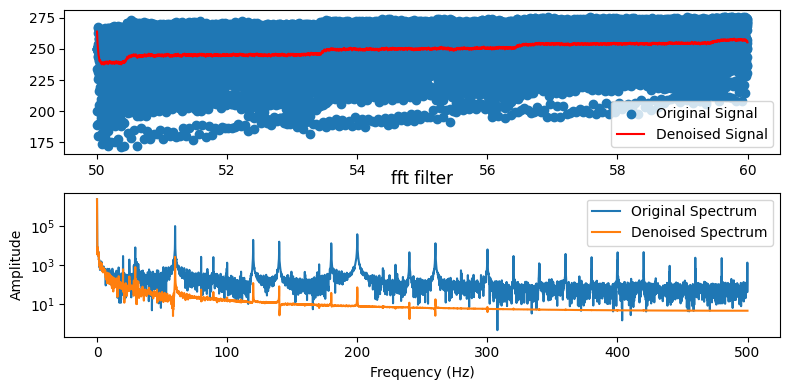

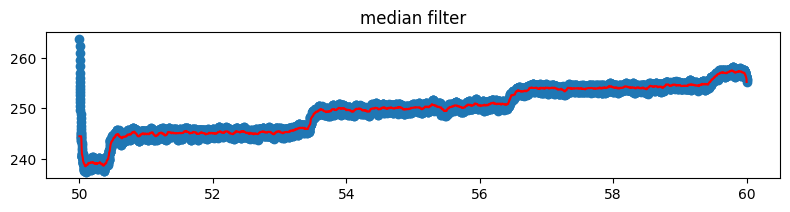

img_rec_mean


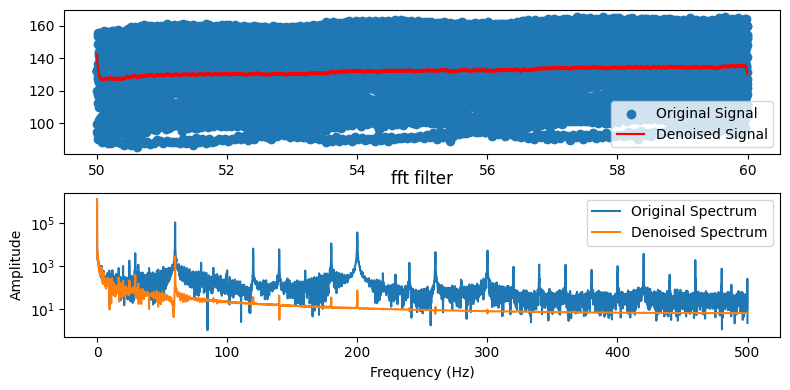

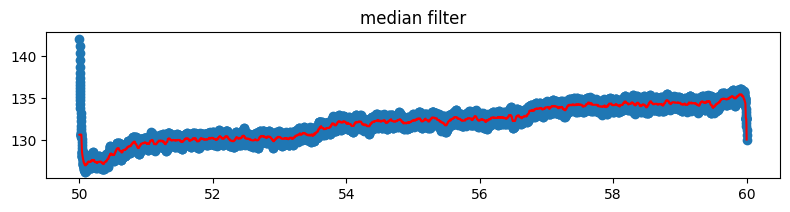

In [15]:
temp = 'temp670'
for m in ["height", "x", "y", "width_x", "width_y", 'img_rec_max', 'img_rec_mean']:
    print(m)
    x, y = ds_para.load_curve(growth=temp, spot='spot_2', metric=m, x_start=0)
    data = np.stack([x, y], 1)
    data = select_range(data, start=50, end=60)
    sample_x, sample_y = data[:,0], data[:,1]
    sample_y[:5] = np.mean(sample_y)
    sample_y = denoise_fft(sample_x, sample_y, cutoff_freq=10, denoise_order=1, sample_frequency=1000, viz=True)
    sample_x, sample_y = denoise_median(sample_x, sample_y, kernel_size=51, viz=True)
    x_bg, y_bg = sample_x, sample_y

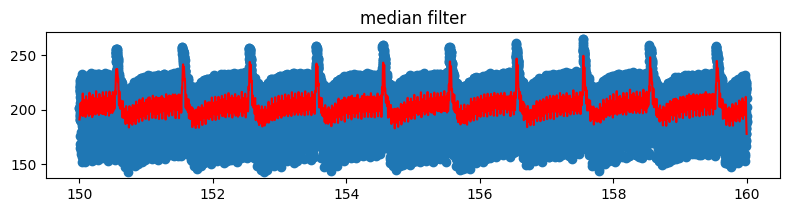

In [61]:
temp = 'temp350'
x, y = ds_para.load_curve(growth=temp, spot='spot_2', metric='img_rec_max', x_start=0)
data = np.stack([x, y], 1)
data = select_range(data, start=150, end=160)
sample_x, sample_y = data[:,0], data[:,1]
sample_y[:5] = np.mean(sample_y)

#         denoised_sample_y = denoise_fft(sample_x, sample_y, cutoff_freq=10, denoise_order=3, sample_frequency=2000)
sample_x, sample_y = denoise_median(sample_x, sample_y, kernel_size=51, viz=True)

In [63]:
range = np.min(sample_y), np.max(sample_y)
y_bg_scaled = range[0] + ((y_bg - np.min(y_bg)) / (np.max(y_bg) - np.min(y_bg))) * (range[1] - range[0])

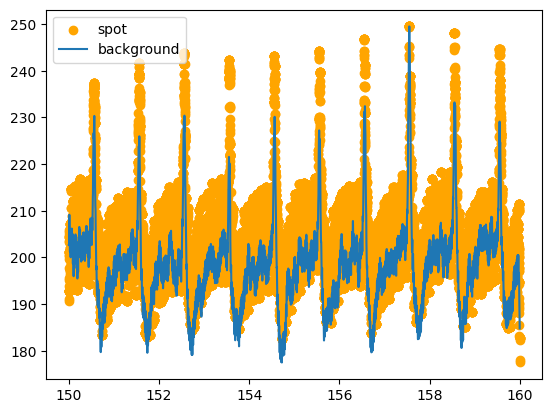

In [73]:
plt.scatter(sample_x, sample_y, label='spot', color='orange')
plt.plot(x_bg, y_bg_scaled, label='background')
plt.legend()

Text(0.5, 1.0, 'Normalized spot intensity')

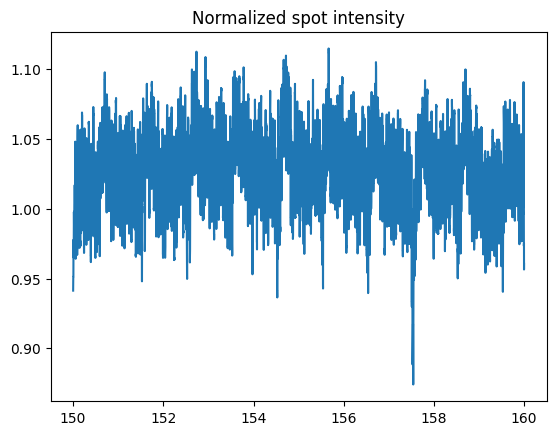

In [74]:
processed_sample_y =  sample_y/y_bg_scaled
plt.plot(sample_x, processed_sample_y)
plt.title('Normalized spot intensity')

temp250


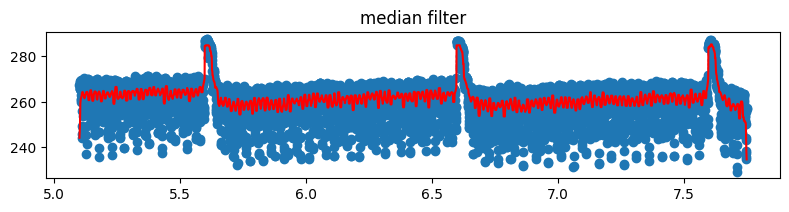

temp300


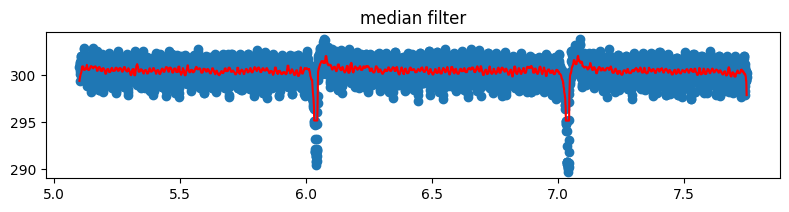

temp350


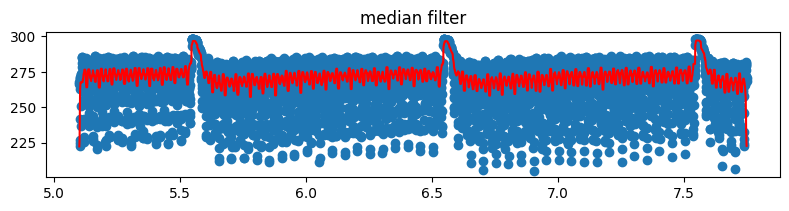

In [6]:
for temp in ['temp250', 'temp300', 'temp350']:
    x, y = ds_para.load_curve(growth=temp, spot='spot_2', metric='img_rec_max', x_start=0)
    sample_x, sample_y = x[10200:15500], y[10200:15500]
    print(temp)
    data = np.stack([sample_x, sample_y], 1)
    #         denoised_sample_y = denoise_fft(sample_x, sample_y, cutoff_freq=10, denoise_order=3, sample_frequency=2000)
    sample_x, sample_y = denoise_median(sample_x, sample_y, kernel_size=51, viz=True)

('img_rec_sum', 'spot_2')


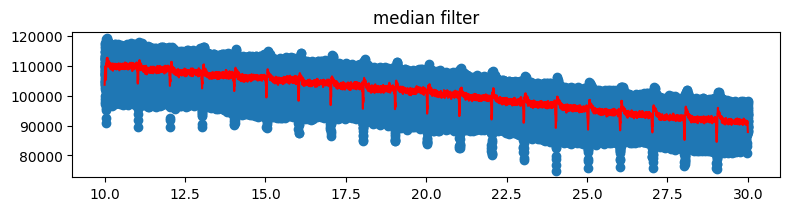

('img_rec_max', 'spot_2')


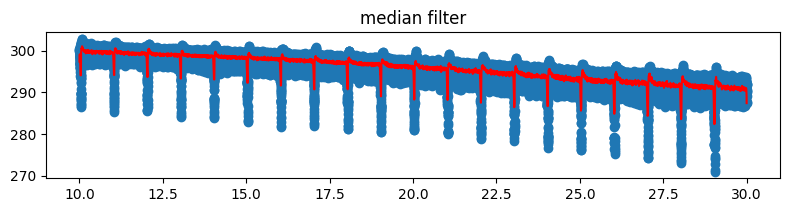

('height', 'spot_2')


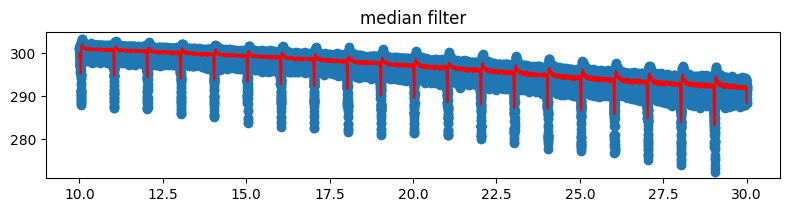

('x', 'spot_1')


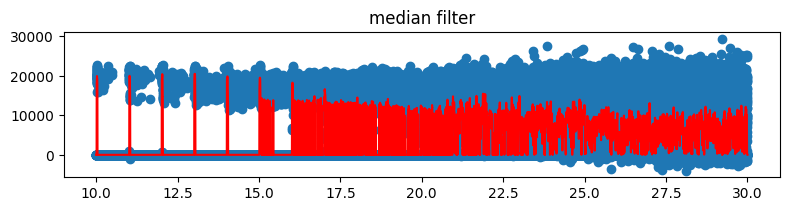

In [7]:
ranges_list = [(0, 20), (0, 20), (0, 20), (0, 20)]
m_spot_list = [("img_rec_sum", 'spot_2'), ("img_rec_max", 'spot_2'), ("height", 'spot_2'), ("x", 'spot_1')]

for m_spot, ranges in zip(m_spot_list, ranges_list):

    print(m_spot)
    m, spot = m_spot
    sample_x, sample_y = ds_para.load_curve(growth='temp300', spot=spot, metric=m, x_start=0)
    data = np.stack([sample_x, sample_y], 1)
    data = select_range(data, 10, 30)
    sample_x, sample_y = data[:, 0], data[:, 1]
    #         denoised_sample_y = denoise_fft(sample_x, sample_y, cutoff_freq=10, denoise_order=3, sample_frequency=2000)
    sample_x, sample_y = denoise_median(sample_x, sample_y, kernel_size=51, viz=True)

temp250


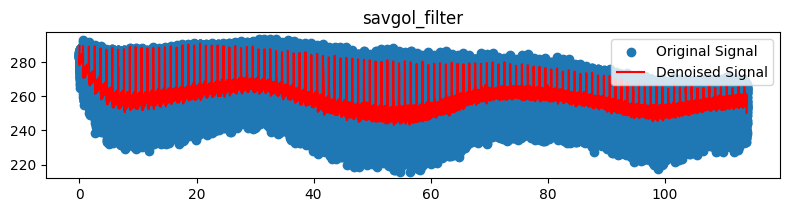

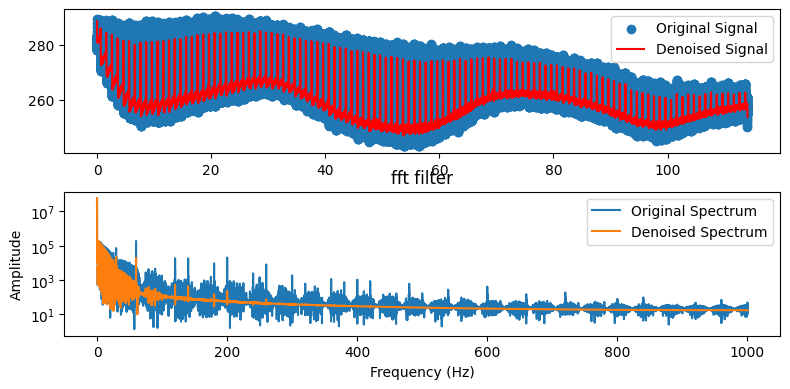

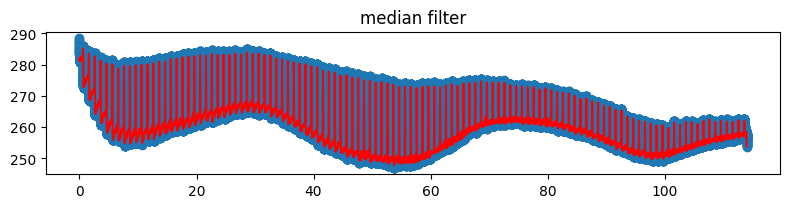

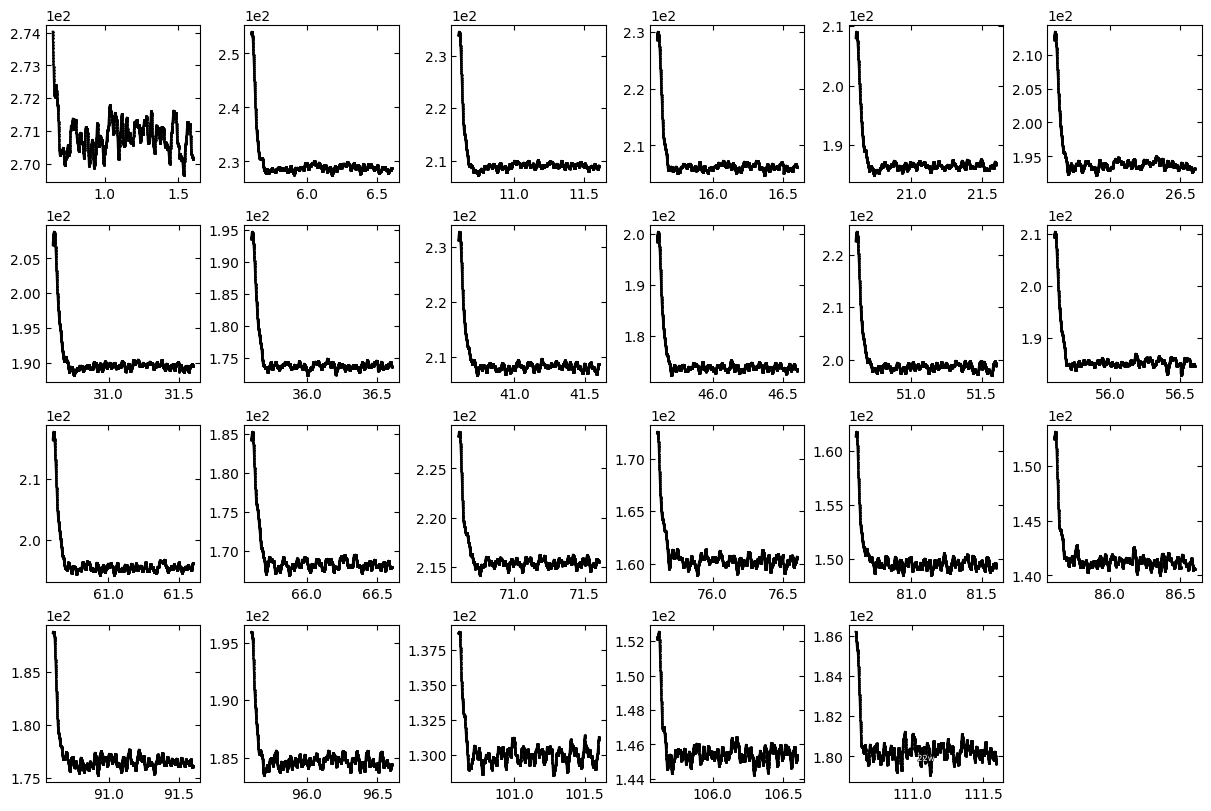

<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
../../src\m3_learning\RHEED\Analysis_umich.py:59: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ys_nor_all = np.array(ys_nor_all)
../../src\m3_learning\RHEED\Analysis_umich.py:60: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ys_nor_fit_all = np.array(ys

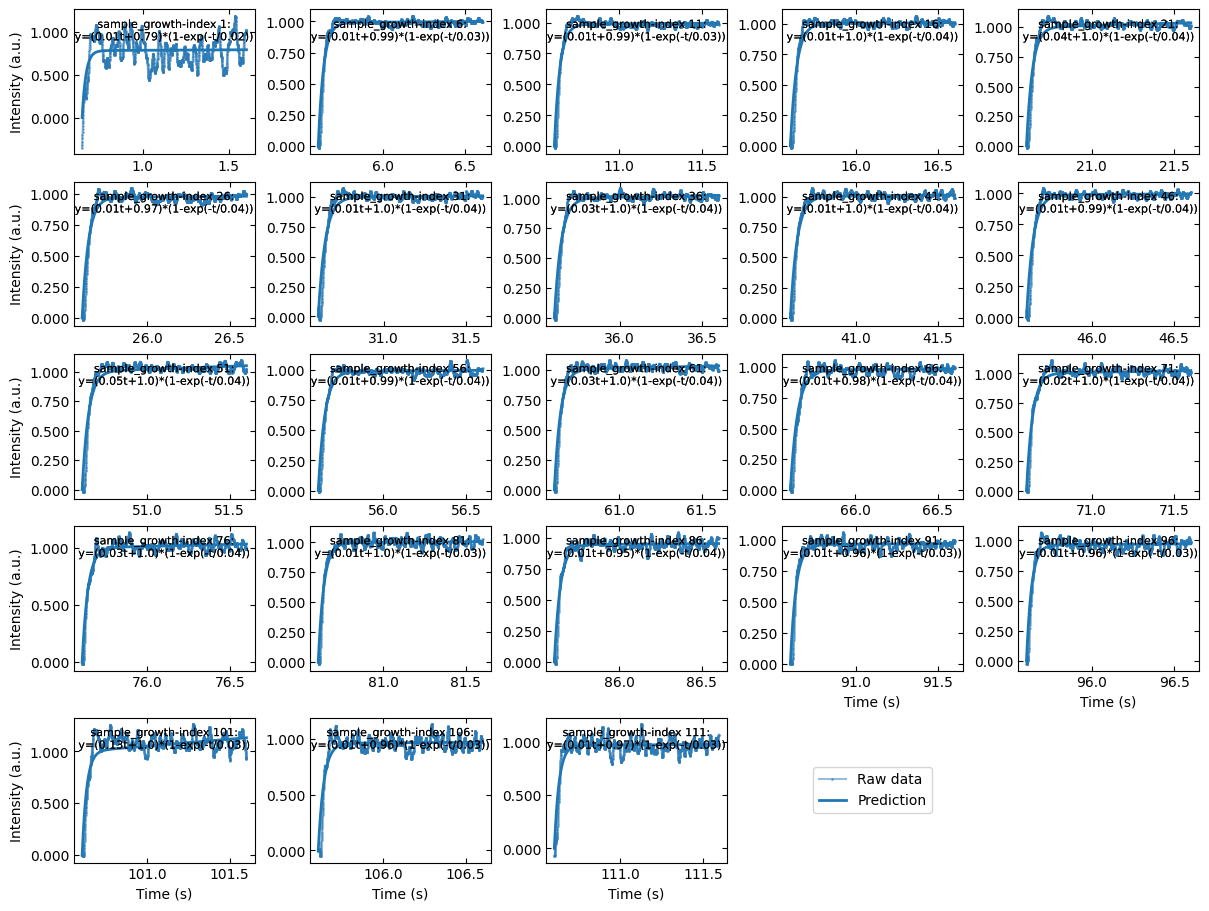

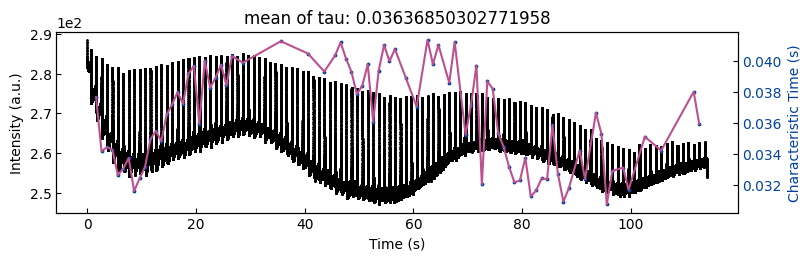

temp300


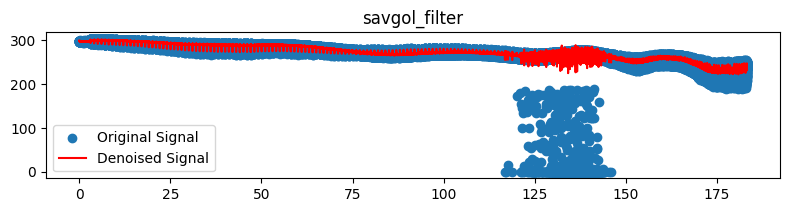

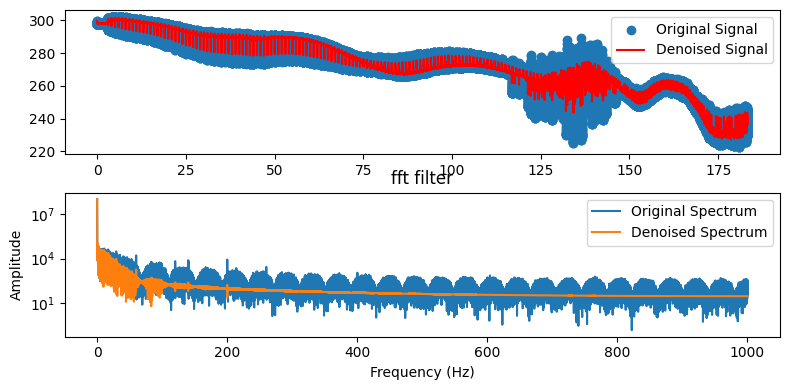

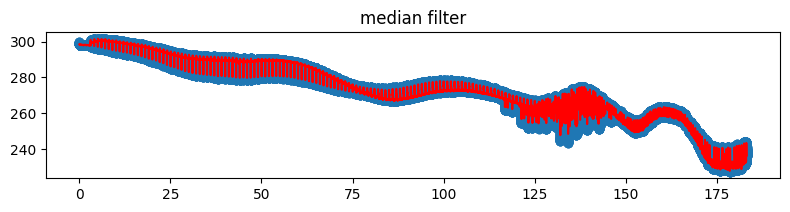

c:\Users\yig319\Anaconda3\envs\m3\lib\site-packages\scipy\optimize\_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


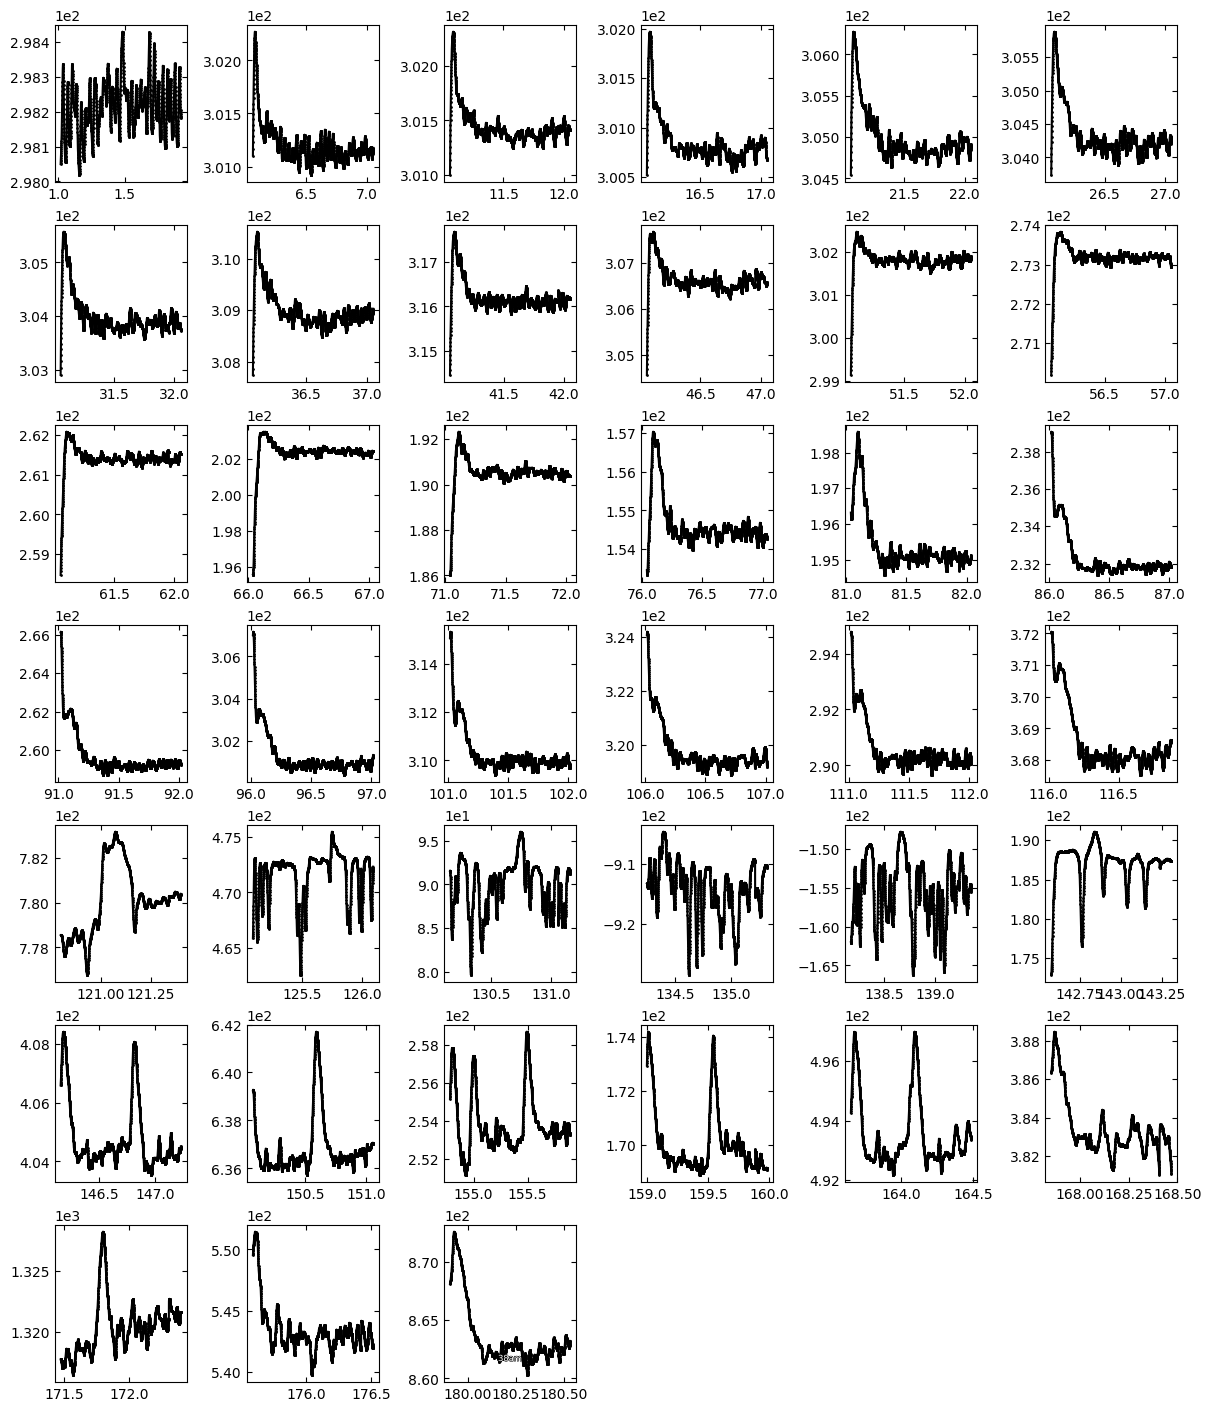

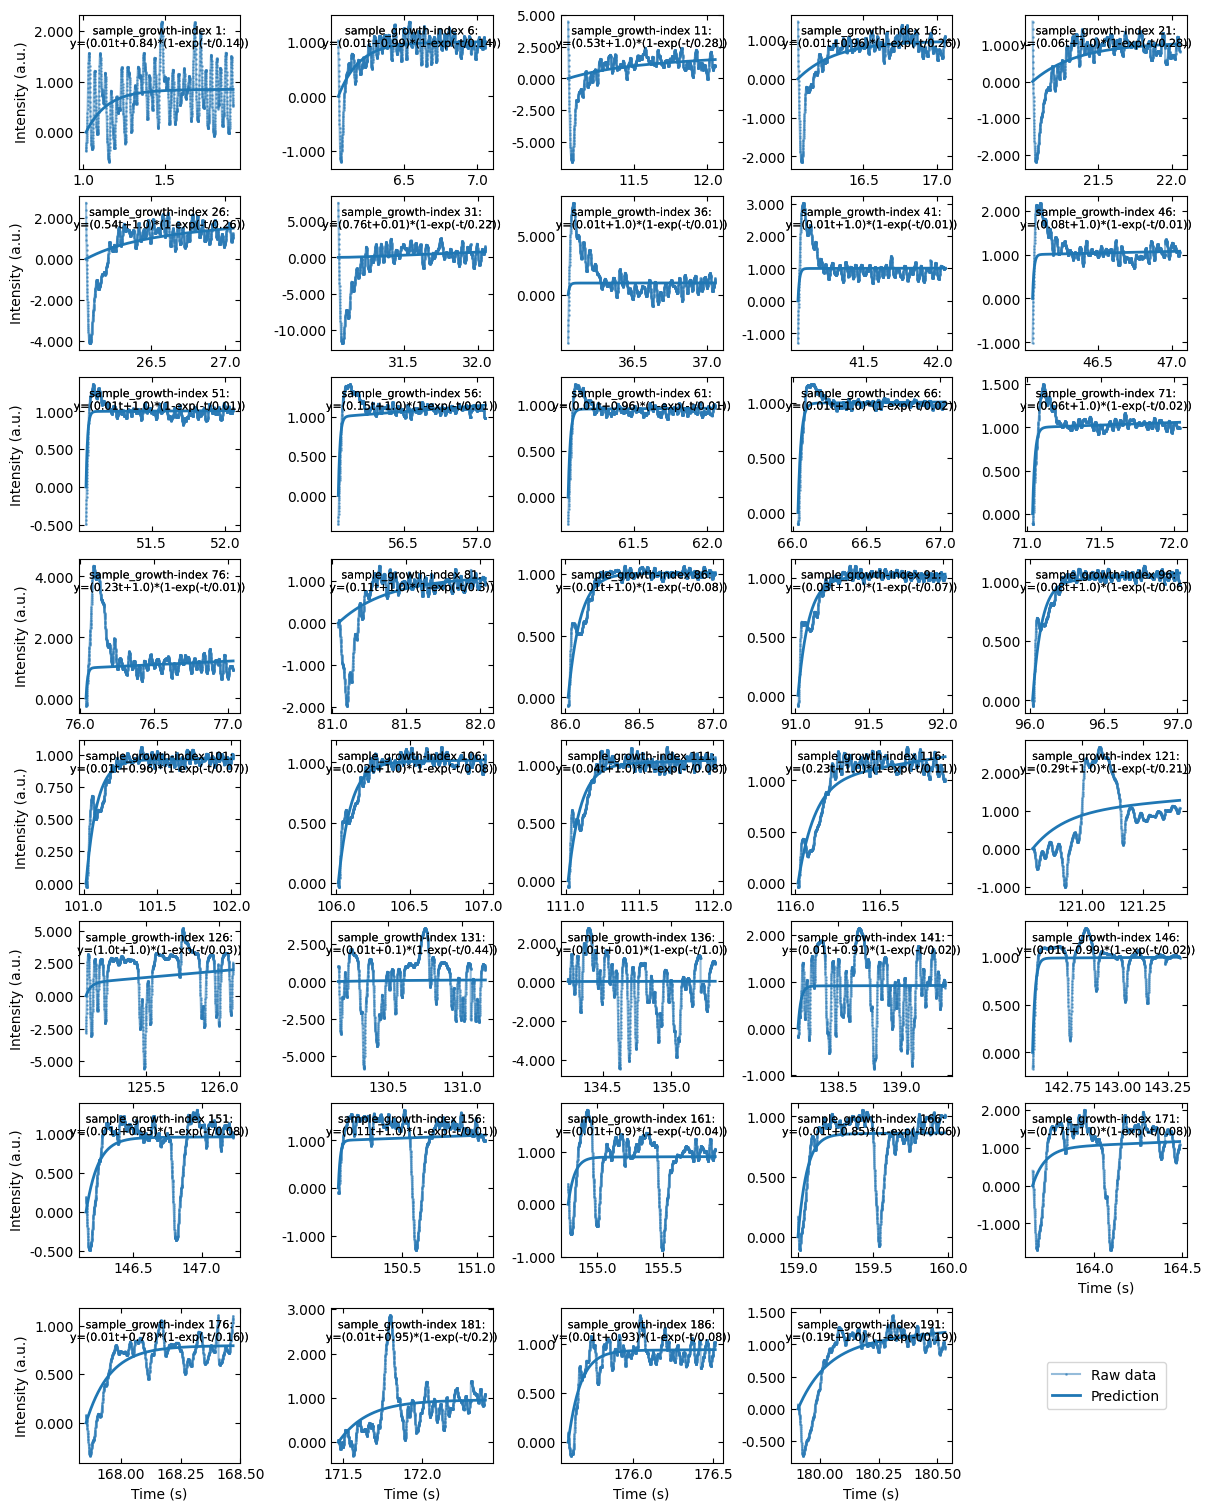

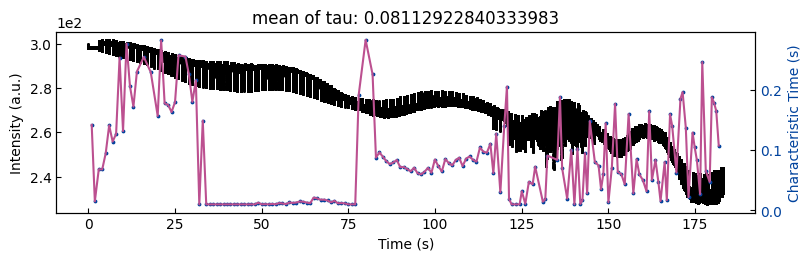

temp350


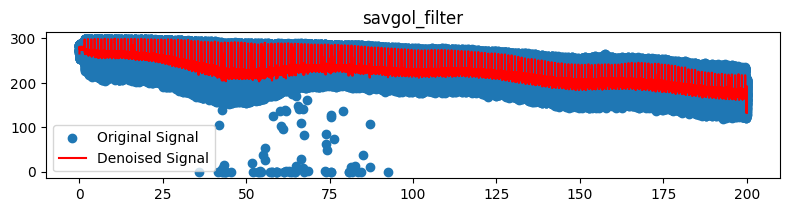

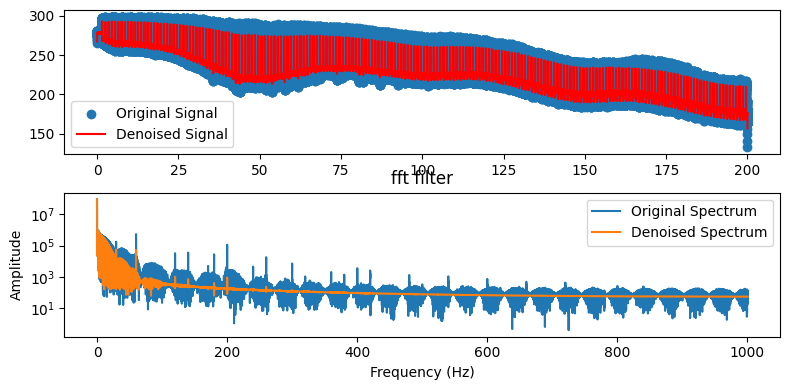

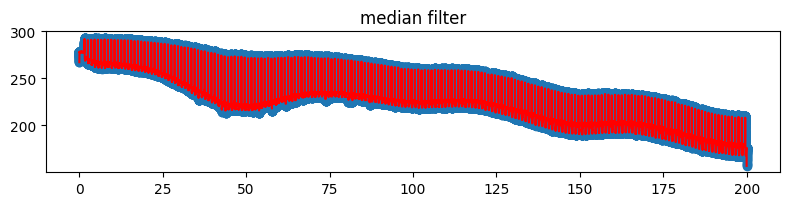

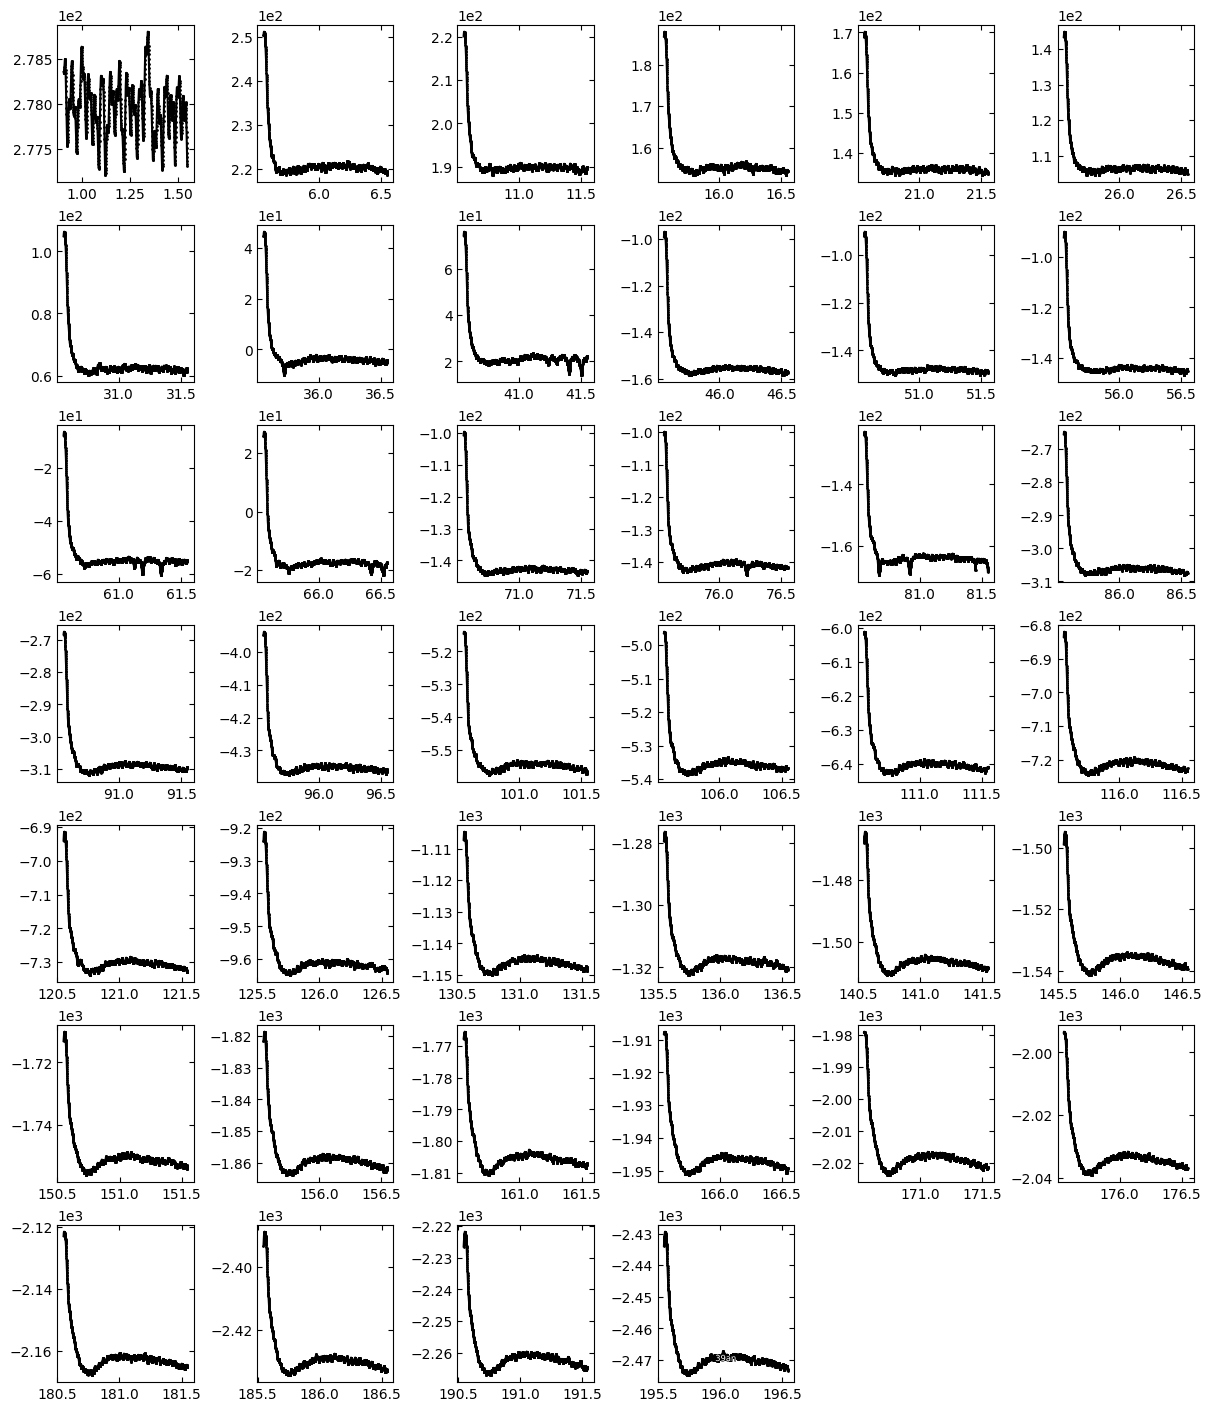

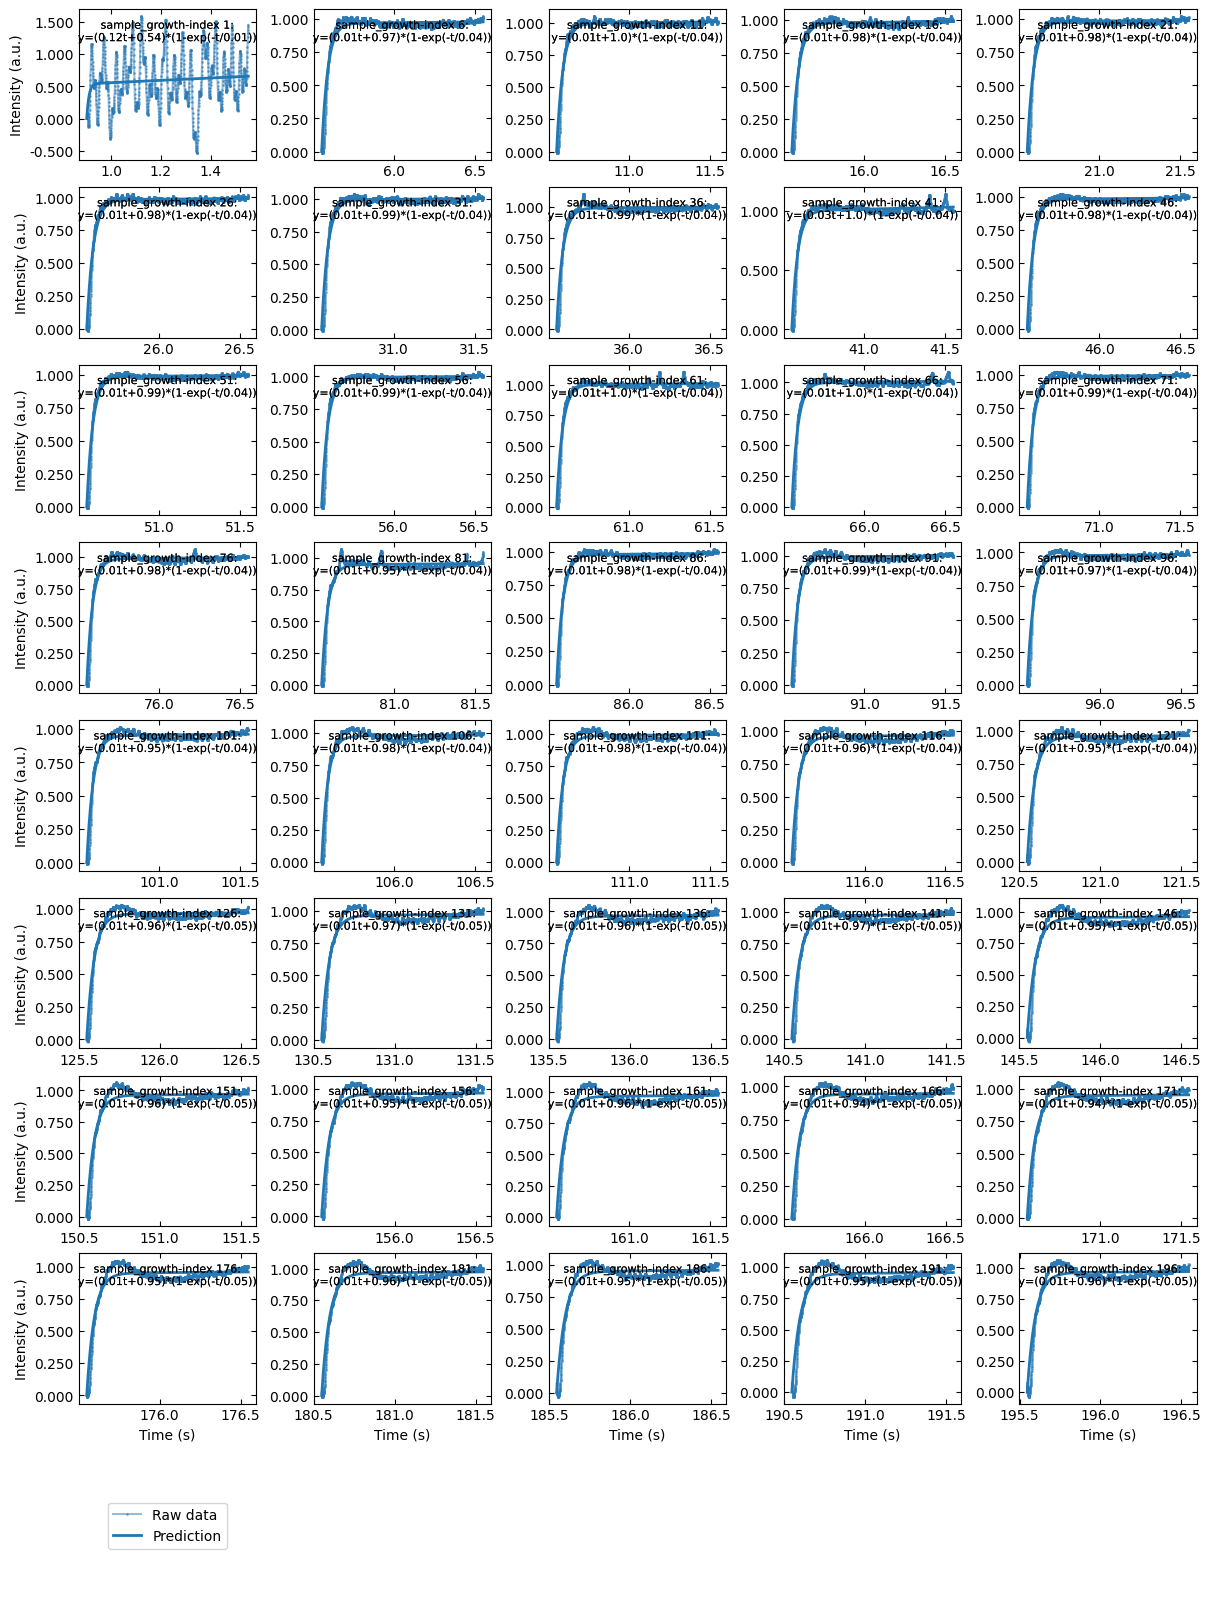

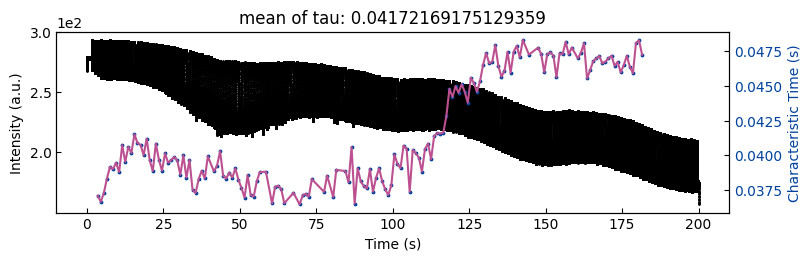

In [8]:
# denoise_params = {'savgol_window_order': (51,3), 'pca_component': 3, 'fft_cutoff_order':(20, 1), 'median_kernel_size':51}
denoise_params = {'savgol_window_order': (51, 3), 'pca_component': None, 'fft_cutoff_order':(5, 1), 'median_kernel_size':51}
curve_params = {'trim_first':0, 'tune_tail':True, 'convolve_step':15, 'prominence':0.2, 'mode':'full', 'linear_ratio':0.8}
normalize_params = {'I_diff': None, 'unify':True, 'bounds':[0.01, 1], 'p_init':(1, 0.1, 0.4), 'n_std':1}
viz_params = {'viz_denoise': True, 'viz_curves': True, 'viz_fittings': True, 'viz_ab': False}
    
laser_freq = 1
camera_freq = 2000

ranges_list = [(0, 114), (0, 200), (0, 200)]
temp_list = ['temp250', 'temp300', 'temp350']

for temp, ranges in zip(temp_list, ranges_list):
    sample_x, sample_y = ds_para.load_curve(growth=temp, spot='spot_2', metric='img_rec_max', x_start=0)
    print(temp)
    data = np.stack([sample_x, sample_y], 1)
    data = select_range(data, *ranges)

    parameters_all, x_list_all, info, tau = analyze_rheed_data(data, camera_freq, laser_freq, denoise_params, curve_params, normalize_params, viz_params)

temp250


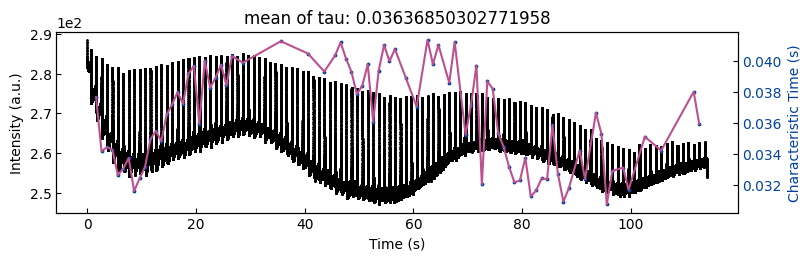

temp300


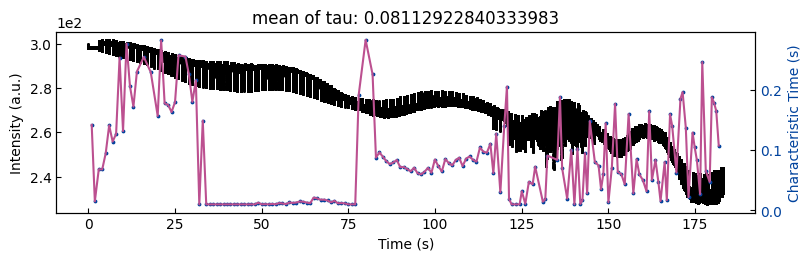

temp350


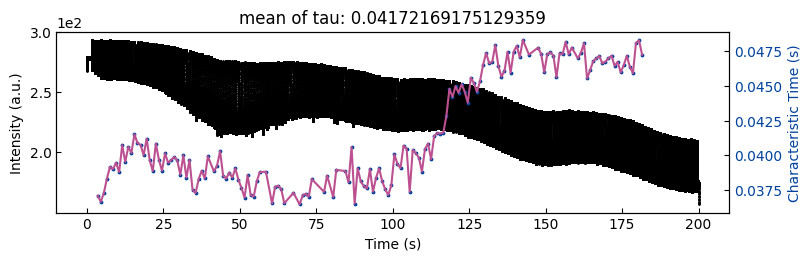

In [9]:
# denoise_params = {'savgol_window_order': (51,3), 'pca_component': 3, 'fft_cutoff_order':(20, 1), 'median_kernel_size':51}
denoise_params = {'savgol_window_order': (51, 3), 'pca_component': None, 'fft_cutoff_order':(5, 1), 'median_kernel_size':51}
curve_params = {'trim_first':0, 'tune_tail':True, 'convolve_step':15, 'prominence':0.2, 'mode':'full', 'linear_ratio':0.8}
normalize_params = {'I_diff': None, 'unify':True, 'bounds':[0.01, 1], 'p_init':(1, 0.1, 0.4), 'n_std':1}
viz_params = {'viz_denoise': False, 'viz_curves': False, 'viz_fittings': False, 'viz_ab': False}
    
laser_freq = 1
camera_freq = 2000

ranges_list = [(0, 114), (0, 200), (0, 200)]
temp_list = ['temp250', 'temp300', 'temp350']
T_list, tau_list = [250, 300, 350], []
for temp, ranges in zip(temp_list, ranges_list):
    sample_x, sample_y = ds_para.load_curve(growth=temp, spot='spot_2', metric='img_rec_max', x_start=0)
    print(temp)
    data = np.stack([sample_x, sample_y], 1)
    data = select_range(data, *ranges)

    parameters_all, x_list_all, info, tau = analyze_rheed_data(data, camera_freq, laser_freq, denoise_params, curve_params, normalize_params, viz_params)
    tau_list.append(tau)

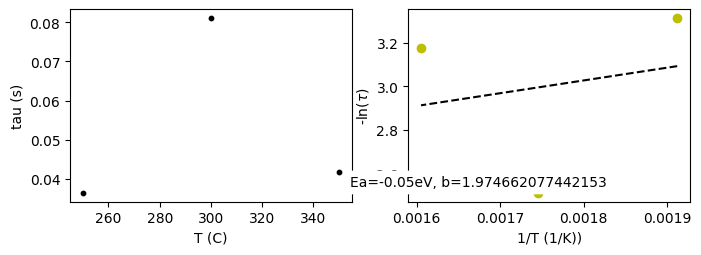

In [10]:
plot_activation_energy(T_list, tau_list)

In [11]:
T_list

[250, 300, 350]

In [12]:
np.save('./Saved_data/tau_PM04_350C.npy', tau_list[0])
np.save('./Saved_data/tau_PM05_300C.npy', tau_list[1])
np.save('./Saved_data/tau_PM06_250C.npy', tau_list[2])

In [22]:
tau_list.append(np.load('./Saved_data/tau_PM08_500C.npy'))
T_list.append(500)

tau_list.append(np.load('./Saved_data/tau_PM09_550C.npy'))
T_list.append(550)

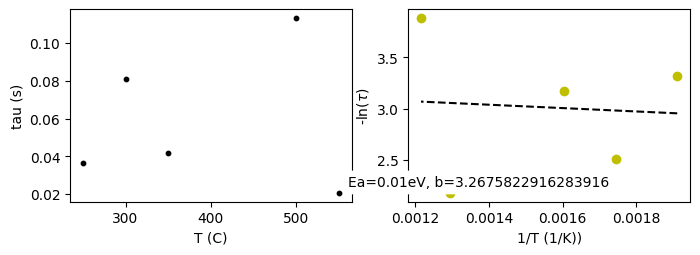

In [23]:
plot_activation_energy(T_list, tau_list)